In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, log_loss, average_precision_score
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.combine import SMOTETomek, SMOTEENN

import xgboost as xgb

import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from optuna.samplers import TPESampler

from flaml import AutoML
from flaml.automl.data import get_output_from_log

warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

# Binary Classification

In [7]:
df_binary = pd.read_csv("binary.csv")
df_binary.columns = df_binary.columns.str.lower()
df_binary = df_binary.drop("time", axis=1)
df_binary.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<Axes: xlabel='class', ylabel='count'>

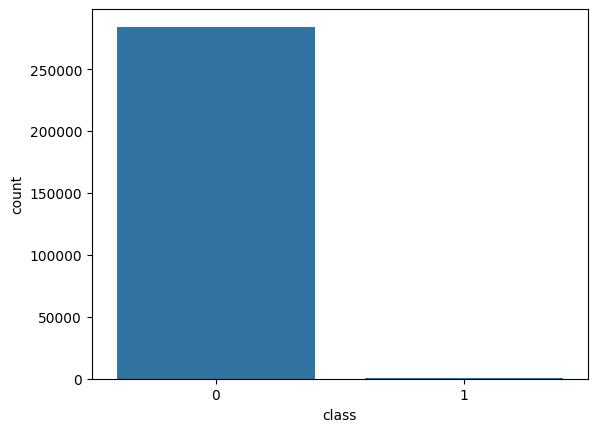

In [9]:
sns.countplot(data=df_binary, x="class")

In [11]:
X = df_binary.drop("class", axis=1).copy()
y = df_binary["class"].copy()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

print(f"Training dataset\t: {len(X_train)}\t({round(len(X_train) / len(X) * 100)}%)")
print(f"Testing dataset\t\t: {len(X_test)}\t\t({round(len(X_test) / len(X) * 100)}%)")

Training dataset	: 199364	(70%)
Testing dataset		: 85443		(30%)


In [17]:
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

In [36]:
default_xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    missing=np.nan,
    seed=42,
    eval_metric="aucpr",
    early_stopping_rounds=10
)
default_xgb_model.fit(
    X_train,
    y_train,
    verbose=True,
    eval_set=[(X_train, y_train), (X_test, y_test)]
)

[0]	validation_0-aucpr:0.76467	validation_1-aucpr:0.69903
[1]	validation_0-aucpr:0.83501	validation_1-aucpr:0.77041
[2]	validation_0-aucpr:0.85435	validation_1-aucpr:0.79552
[3]	validation_0-aucpr:0.85845	validation_1-aucpr:0.80237
[4]	validation_0-aucpr:0.88661	validation_1-aucpr:0.80808
[5]	validation_0-aucpr:0.89704	validation_1-aucpr:0.80680
[6]	validation_0-aucpr:0.89985	validation_1-aucpr:0.80948
[7]	validation_0-aucpr:0.90314	validation_1-aucpr:0.80942
[8]	validation_0-aucpr:0.90822	validation_1-aucpr:0.81647
[9]	validation_0-aucpr:0.91306	validation_1-aucpr:0.82055
[10]	validation_0-aucpr:0.91671	validation_1-aucpr:0.82287
[11]	validation_0-aucpr:0.92246	validation_1-aucpr:0.82506
[12]	validation_0-aucpr:0.92869	validation_1-aucpr:0.82597
[13]	validation_0-aucpr:0.93507	validation_1-aucpr:0.82656
[14]	validation_0-aucpr:0.94095	validation_1-aucpr:0.83193
[15]	validation_0-aucpr:0.94579	validation_1-aucpr:0.83207
[16]	validation_0-aucpr:0.95220	validation_1-aucpr:0.83184
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
default_xgb_model_smoteenn = xgb.XGBClassifier(
    objective="binary:logistic",
    missing=np.nan,
    seed=42,
    eval_metric="aucpr",
    early_stopping_rounds=10
)
default_xgb_model_smoteenn.fit(
    X_train_smoteenn,
    y_train_smoteenn,
    verbose=True,
    eval_set=[(X_train_smoteenn, y_train_smoteenn), (X_test, y_test)]
)

[0]	validation_0-aucpr:0.99525	validation_1-aucpr:0.39987
[1]	validation_0-aucpr:0.99801	validation_1-aucpr:0.61900
[2]	validation_0-aucpr:0.99863	validation_1-aucpr:0.63061
[3]	validation_0-aucpr:0.99886	validation_1-aucpr:0.63855
[4]	validation_0-aucpr:0.99920	validation_1-aucpr:0.68390
[5]	validation_0-aucpr:0.99937	validation_1-aucpr:0.69193
[6]	validation_0-aucpr:0.99950	validation_1-aucpr:0.69241
[7]	validation_0-aucpr:0.99956	validation_1-aucpr:0.69415
[8]	validation_0-aucpr:0.99961	validation_1-aucpr:0.69919
[9]	validation_0-aucpr:0.99967	validation_1-aucpr:0.70096
[10]	validation_0-aucpr:0.99970	validation_1-aucpr:0.70033
[11]	validation_0-aucpr:0.99972	validation_1-aucpr:0.69730
[12]	validation_0-aucpr:0.99974	validation_1-aucpr:0.69815
[13]	validation_0-aucpr:0.99982	validation_1-aucpr:0.73106
[14]	validation_0-aucpr:0.99984	validation_1-aucpr:0.73456
[15]	validation_0-aucpr:0.99987	validation_1-aucpr:0.73240
[16]	validation_0-aucpr:0.99990	validation_1-aucpr:0.73701
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [24]:
def objective(trial):
    params = {
        "objective": "binary:logistic",
        # "n_estimators": trial.suggest_int("n_estimators", 1000, 20000),
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "seed": 42,
        "eval_metric": "aucpr",
        "early_stopping_rounds": 10
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)

    # proba_predictions = model.predict_proba(X_test)[:, 1]
    # aucpr = average_precision_score(y_test, proba_predictions)

    return accuracy

sampler = optuna.samplers.TPESampler(multivariate=True, group=True)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=30, show_progress_bar=True)

c:\Users\User\anaconda3\envs\automl\lib\site-packages\optuna\samplers\_tpe\sampler.py:295: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\User\anaconda3\envs\automl\lib\site-packages\optuna\samplers\_tpe\sampler.py:306: ExperimentalWarning: ``group`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-10-27 19:53:52,581] A new study created in memory with name: no-name-3ba15845-5d91-4276-9532-63c1014b5aec


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-27 19:53:59,329] Trial 0 finished with value: 0.9982678510820079 and parameters: {'learning_rate': 0.009304378829631386, 'lambda': 1.3942731719118405e-08, 'alpha': 1.6325504824066465e-06, 'max_depth': 5, 'subsample': 0.2409249179569526, 'colsample_bytree': 0.49805065185459163, 'min_child_weight': 20}. Best is trial 0 with value: 0.9982678510820079.
[I 2023-10-27 19:54:01,529] Trial 1 finished with value: 0.9982678510820079 and parameters: {'learning_rate': 0.010308829137195812, 'lambda': 9.990260524933417e-08, 'alpha': 0.5819748518373399, 'max_depth': 8, 'subsample': 0.6988227939210085, 'colsample_bytree': 0.6464858665620059, 'min_child_weight': 9}. Best is trial 0 with value: 0.9982678510820079.
[I 2023-10-27 19:54:03,117] Trial 2 finished with value: 0.9982678510820079 and parameters: {'learning_rate': 0.002852078688563424, 'lambda': 0.015012289240388794, 'alpha': 0.008817605865682306, 'max_depth': 3, 'subsample': 0.3596393838360013, 'colsample_bytree': 0.17156951306814244

In [26]:
optuna_xgb_model = xgb.XGBClassifier(**study.best_params)
optuna_xgb_model.fit(X_train, y_train, verbose=True)

XGBClassifier(alpha=1.593169047781973e-05, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6397064698586328, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=3.3212791765573385e-06,
              learning_rate=0.023941666490444376, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [25]:
def objective(trial):
    params = {
        "objective": "binary:logistic",
        # "n_estimators": trial.suggest_int("n_estimators", 1000, 20000),
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "seed": 42,
        "eval_metric": "aucpr",
        "early_stopping_rounds": 10
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_smoteenn, y_train_smoteenn, eval_set=[(X_test, y_test)], verbose=False)

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)

    # proba_predictions = model.predict_proba(X_test)[:, 1]
    # aucpr = average_precision_score(y_test, proba_predictions)

    return accuracy

sampler = optuna.samplers.TPESampler(multivariate=True, group=True)
study_smoteenn = optuna.create_study(direction="maximize", sampler=sampler)
study_smoteenn.optimize(objective, n_trials=30, show_progress_bar=True)

c:\Users\User\anaconda3\envs\automl\lib\site-packages\optuna\samplers\_tpe\sampler.py:295: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\User\anaconda3\envs\automl\lib\site-packages\optuna\samplers\_tpe\sampler.py:306: ExperimentalWarning: ``group`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-10-27 19:59:35,708] A new study created in memory with name: no-name-3c594d86-355a-4249-8849-04e876bddb80


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-27 19:59:39,437] Trial 0 finished with value: 0.9828423627447538 and parameters: {'learning_rate': 0.00607752760492953, 'lambda': 0.02053830933210645, 'alpha': 0.00015066050438343142, 'max_depth': 2, 'subsample': 0.7714150278373275, 'colsample_bytree': 0.7492386165415971, 'min_child_weight': 17}. Best is trial 0 with value: 0.9828423627447538.
[I 2023-10-27 19:59:46,241] Trial 1 finished with value: 0.9984785178423042 and parameters: {'learning_rate': 0.07191493056180574, 'lambda': 0.059391803543847765, 'alpha': 0.0003986339949427021, 'max_depth': 9, 'subsample': 0.9811214048831071, 'colsample_bytree': 0.31865320520920204, 'min_child_weight': 2}. Best is trial 1 with value: 0.9984785178423042.
[I 2023-10-27 19:59:50,634] Trial 2 finished with value: 0.9925330337183853 and parameters: {'learning_rate': 0.0018292746347845243, 'lambda': 0.0002172374882362275, 'alpha': 3.2247621245207553e-06, 'max_depth': 4, 'subsample': 0.8286125108618956, 'colsample_bytree': 0.3421934399417380

In [27]:
optuna_xgb_model_smoteenn = xgb.XGBClassifier(**study_smoteenn.best_params)
optuna_xgb_model_smoteenn.fit(X_train_smoteenn, y_train_smoteenn, verbose=True)

XGBClassifier(alpha=0.0054430744906085, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.34866813429484966, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.08515926048763849,
              learning_rate=0.09470954143484096, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

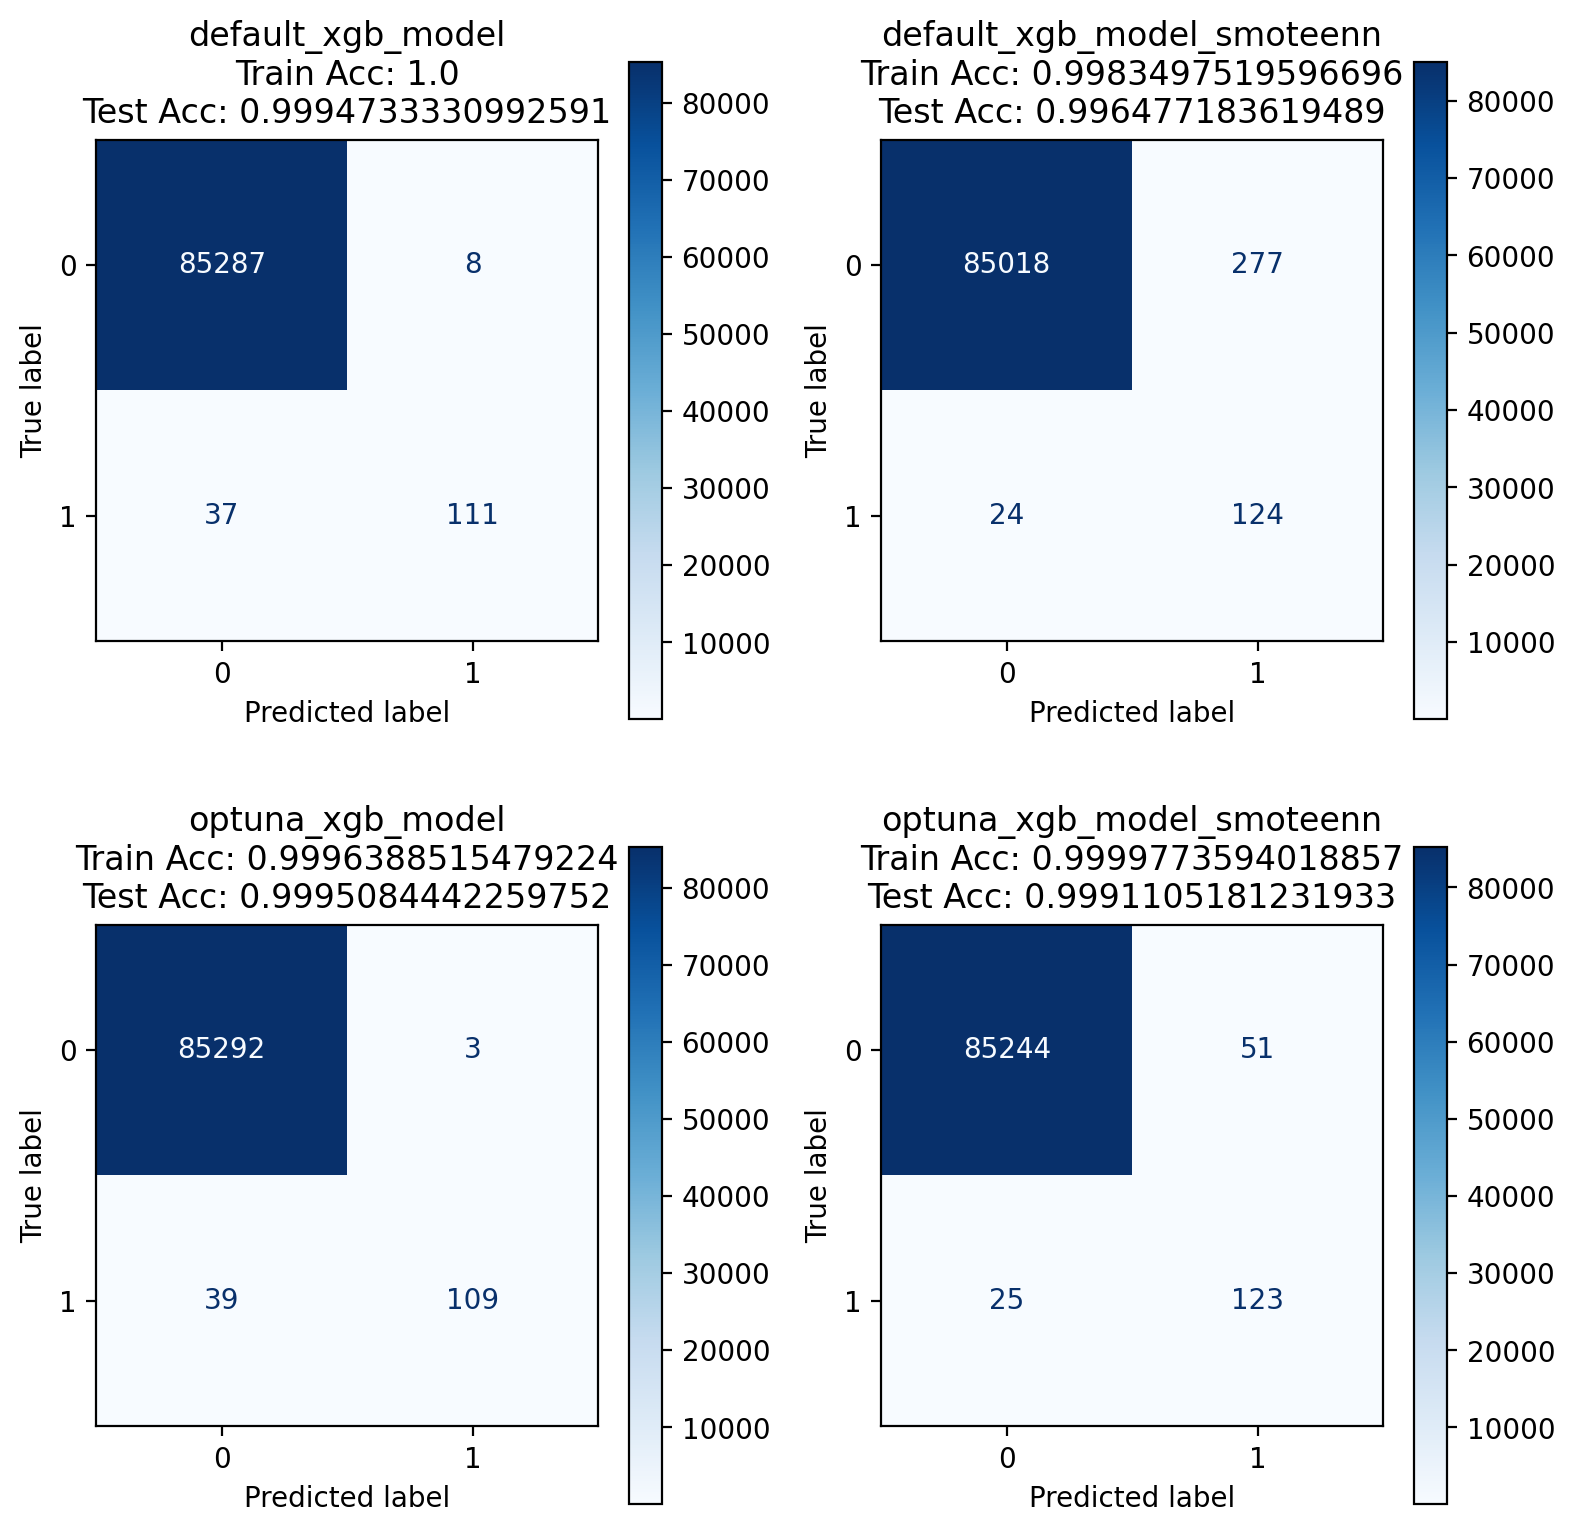

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), dpi=200)
models = {
    "default_xgb_model": (default_xgb_model, X_train, X_test, y_train, y_test),
    "default_xgb_model_smoteenn": (default_xgb_model_smoteenn, X_train_smoteenn, X_test, y_train_smoteenn, y_test),
    "optuna_xgb_model": (optuna_xgb_model, X_train, X_test, y_train, y_test),
    "optuna_xgb_model_smoteenn": (optuna_xgb_model_smoteenn, X_train_smoteenn, X_test, y_train_smoteenn, y_test),
}

wrapper = textwrap.TextWrapper(width=18)

for ax, (model_name, (model, X_train_data, X_test_data, y_train_data, y_test_data)) in zip(axes.flatten(), models.items()):
    y_train_pred = model.predict(X_train_data)
    y_test_pred = model.predict(X_test_data)
    
    train_acc = accuracy_score(y_train_data, y_train_pred)
    test_acc = accuracy_score(y_test_data, y_test_pred)
    
    # disp = ConfusionMatrixDisplay.from_predictions(y_test_data, y_test_pred, display_labels=label_encoder.classes_, cmap="Blues", ax=ax)
    disp = ConfusionMatrixDisplay.from_predictions(y_test_data, y_test_pred, cmap="Blues", ax=ax)
    
    x_labels = ["\n".join(wrapper.wrap(label.get_text())) for label in ax.get_xticklabels()]
    # ax.set_xticklabels(x_labels, rotation=90)
    ax.set_xticklabels(x_labels)

    y_labels = ["\n".join(wrapper.wrap(label.get_text())) for label in ax.get_yticklabels()]
    ax.set_yticklabels(y_labels)
    
    ax.set_title(f"{model_name}\nTrain Acc: {train_acc}\nTest Acc: {test_acc}")

plt.tight_layout()
plt.show()

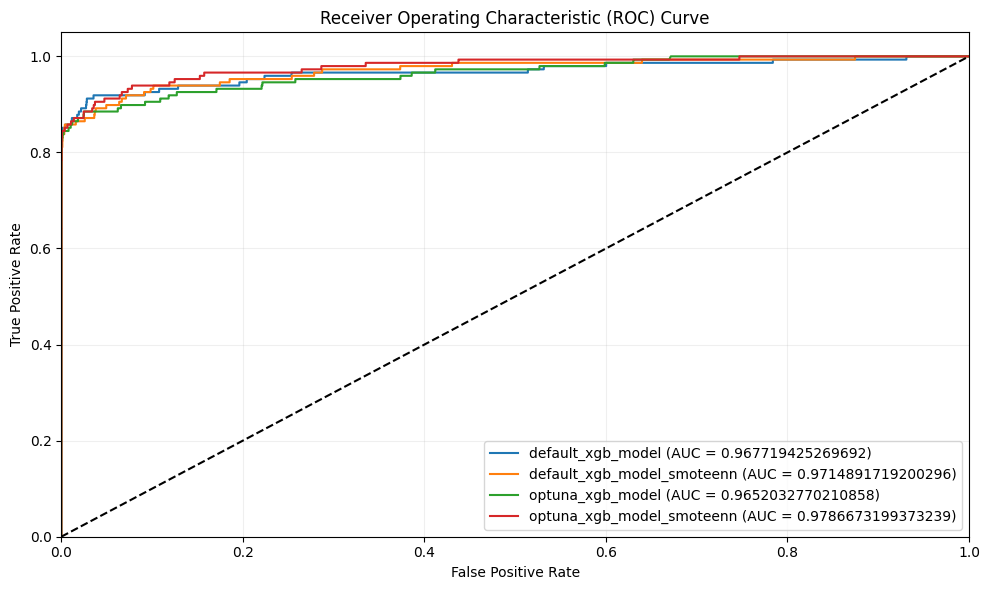

In [44]:
# Models and datasets mapping
models = {
    "default_xgb_model": (default_xgb_model, X_train, X_test, y_train, y_test),
    "default_xgb_model_smoteenn": (default_xgb_model_smoteenn, X_train_smoteenn, X_test, y_train_smoteenn, y_test),
    "optuna_xgb_model": (optuna_xgb_model, X_train, X_test, y_train, y_test),
    "optuna_xgb_model_smoteenn": (optuna_xgb_model_smoteenn, X_train_smoteenn, X_test, y_train_smoteenn, y_test),
}

plt.figure(figsize=(10, 6))

# For each model, calculate the ROC curve and AUC, then plot
for model_name, (model, X_train_data, X_test_data, y_train_data, y_test_data) in models.items():
    # Calculate predicted probabilities
    y_pred_prob = model.predict_proba(X_test_data)[:, 1]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_data, y_pred_prob)
    
    # Calculate the area under the ROC curve
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    # plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc})")

# Settings for the ROC curve plot
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Multiclass Classification

In [71]:
df_multi = pd.read_csv("multiclass.csv")
df_multi.columns = df_multi.columns.str.lower().str.replace(" ", "_").str.replace("[", "").str.replace("]", "")
df_multi = df_multi.drop(["udi", "product_id"], axis=1)
df_multi.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,target,failure_type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


In [72]:
for col in df_multi.columns:
    print(f"{col}: {df_multi[col].nunique()}")

type: 3
air_temperature_k: 93
process_temperature_k: 82
rotational_speed_rpm: 941
torque_nm: 577
tool_wear_min: 246
target: 2
failure_type: 6


In [73]:
X = df_multi.drop("failure_type", axis=1).copy()
X.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


In [74]:
X_encoded = pd.get_dummies(X, drop_first=True).astype(float)
X_encoded.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,target,type_L,type_M
0,298.1,308.6,1551.0,42.8,0.0,0.0,0.0,1.0
1,298.2,308.7,1408.0,46.3,3.0,0.0,1.0,0.0
2,298.1,308.5,1498.0,49.4,5.0,0.0,1.0,0.0
3,298.2,308.6,1433.0,39.5,7.0,0.0,1.0,0.0
4,298.2,308.7,1408.0,40.0,9.0,0.0,1.0,0.0


In [75]:
y = df_multi["failure_type"].copy()
y.head()

0    No Failure
1    No Failure
2    No Failure
3    No Failure
4    No Failure
Name: failure_type, dtype: object

In [76]:
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)
y_encoded

array([1, 1, 1, ..., 1, 1, 1])

In [77]:
df_encoding = pd.DataFrame({
    "Encoded_Label": range(len(label_encoder.classes_)),
    "Original_Label": label_encoder.classes_
})
df_encoding

,Encoded_Label,Original_Label
0,0,Heat Dissipation Failure
1,1,No Failure
2,2,Overstrain Failure
3,3,Power Failure
4,4,Random Failures
5,5,Tool Wear Failure


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, random_state=42, test_size=0.3, stratify=y_encoded)

print(f"Training dataset\t: {len(X_train)}\t({round(len(X_train) / len(X) * 100)}%)")
print(f"Testing dataset\t\t: {len(X_test)}\t({round(len(X_test) / len(X) * 100)}%)")

Training dataset	: 7000	(70%)
Testing dataset		: 3000	(30%)


In [79]:
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

In [80]:
default_xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    missing=np.nan,
    seed=42,
    eval_metric="aucpr",
    early_stopping_rounds=10
)
default_xgb_model.fit(
    X_train,
    y_train,
    verbose=True,
    eval_set=[(X_train, y_train), (X_test, y_test)]
)

[0]	validation_0-aucpr:0.82379	validation_1-aucpr:0.82121
[1]	validation_0-aucpr:0.82591	validation_1-aucpr:0.82494


[2]	validation_0-aucpr:0.82987	validation_1-aucpr:0.82677
[3]	validation_0-aucpr:0.83138	validation_1-aucpr:0.82758
[4]	validation_0-aucpr:0.83383	validation_1-aucpr:0.82813
[5]	validation_0-aucpr:0.83590	validation_1-aucpr:0.82827
[6]	validation_0-aucpr:0.83792	validation_1-aucpr:0.82774
[7]	validation_0-aucpr:0.84682	validation_1-aucpr:0.82833
[8]	validation_0-aucpr:0.86593	validation_1-aucpr:0.83050
[9]	validation_0-aucpr:0.87361	validation_1-aucpr:0.82898
[10]	validation_0-aucpr:0.88352	validation_1-aucpr:0.82791
[11]	validation_0-aucpr:0.89007	validation_1-aucpr:0.82805
[12]	validation_0-aucpr:0.90151	validation_1-aucpr:0.82805
[13]	validation_0-aucpr:0.90881	validation_1-aucpr:0.82760
[14]	validation_0-aucpr:0.91505	validation_1-aucpr:0.82742
[15]	validation_0-aucpr:0.92348	validation_1-aucpr:0.82909
[16]	validation_0-aucpr:0.93162	validation_1-aucpr:0.82966
[17]	validation_0-aucpr:0.94050	validation_1-aucpr:0.82963


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [81]:
default_xgb_model_smoteenn = xgb.XGBClassifier(
    objective="multi:softmax",
    missing=np.nan,
    seed=42,
    eval_metric="aucpr",
    early_stopping_rounds=10
)
default_xgb_model_smoteenn.fit(
    X_train_smoteenn,
    y_train_smoteenn,
    verbose=True,
    eval_set=[(X_train_smoteenn, y_train_smoteenn), (X_test, y_test)]
)

[0]	validation_0-aucpr:0.96477	validation_1-aucpr:0.79228
[1]	validation_0-aucpr:0.98406	validation_1-aucpr:0.79989
[2]	validation_0-aucpr:0.98795	validation_1-aucpr:0.81006
[3]	validation_0-aucpr:0.99012	validation_1-aucpr:0.81308
[4]	validation_0-aucpr:0.99113	validation_1-aucpr:0.81427
[5]	validation_0-aucpr:0.99511	validation_1-aucpr:0.81714
[6]	validation_0-aucpr:0.99702	validation_1-aucpr:0.81707
[7]	validation_0-aucpr:0.99771	validation_1-aucpr:0.81711
[8]	validation_0-aucpr:0.99814	validation_1-aucpr:0.81760
[9]	validation_0-aucpr:0.99841	validation_1-aucpr:0.81806
[10]	validation_0-aucpr:0.99869	validation_1-aucpr:0.81754
[11]	validation_0-aucpr:0.99881	validation_1-aucpr:0.81665
[12]	validation_0-aucpr:0.99895	validation_1-aucpr:0.81666
[13]	validation_0-aucpr:0.99928	validation_1-aucpr:0.81644
[14]	validation_0-aucpr:0.99942	validation_1-aucpr:0.81663
[15]	validation_0-aucpr:0.99952	validation_1-aucpr:0.81628
[16]	validation_0-aucpr:0.99957	validation_1-aucpr:0.81618
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [82]:
def objective(trial):
    params = {
        "objective": "multi:softmax",
        # "n_estimators": trial.suggest_int("n_estimators", 1000, 20000),
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "seed": 42,
        "eval_metric": "aucpr",
        "early_stopping_rounds": 10
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)

    # proba_predictions = model.predict_proba(X_test)[:, 1]
    # aucpr = average_precision_score(y_test, proba_predictions)

    return accuracy

sampler = optuna.samplers.TPESampler(multivariate=True, group=True)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=30, show_progress_bar=True)

c:\Users\User\anaconda3\envs\automl\lib\site-packages\optuna\samplers\_tpe\sampler.py:295: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\User\anaconda3\envs\automl\lib\site-packages\optuna\samplers\_tpe\sampler.py:306: ExperimentalWarning: ``group`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-10-27 20:50:48,690] A new study created in memory with name: no-name-fd58ad9c-e604-4a52-8f8c-86a3104041f8


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-27 20:50:49,201] Trial 0 finished with value: 0.9653333333333334 and parameters: {'learning_rate': 0.017261273208982866, 'lambda': 0.0009150312519760798, 'alpha': 7.374381783501004e-05, 'max_depth': 5, 'subsample': 0.059050899574280766, 'colsample_bytree': 0.6683435288933145, 'min_child_weight': 6}. Best is trial 0 with value: 0.9653333333333334.
[I 2023-10-27 20:50:49,551] Trial 1 finished with value: 0.9653333333333334 and parameters: {'learning_rate': 0.009919371545470158, 'lambda': 2.9304940930771823e-06, 'alpha': 0.000758942907591301, 'max_depth': 6, 'subsample': 0.6674073875164148, 'colsample_bytree': 0.07781407180934202, 'min_child_weight': 15}. Best is trial 0 with value: 0.9653333333333334.
[I 2023-10-27 20:50:49,730] Trial 2 finished with value: 0.98 and parameters: {'learning_rate': 0.035980154024369465, 'lambda': 0.0006014364872253029, 'alpha': 0.11238195076539242, 'max_depth': 1, 'subsample': 0.8075589841665092, 'colsample_bytree': 0.7027445476002644, 'min_child

In [83]:
optuna_xgb_model = xgb.XGBClassifier(**study.best_params)
optuna_xgb_model.fit(X_train, y_train, verbose=True)

XGBClassifier(alpha=2.3287013199080684e-08, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8863586996839318, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=4.433662662816032e-08,
              learning_rate=0.004556013365380151, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [84]:
def objective(trial):
    params = {
        "objective": "multi:softmax",
        # "n_estimators": trial.suggest_int("n_estimators", 1000, 20000),
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "seed": 42,
        "eval_metric": "aucpr",
        "early_stopping_rounds": 10
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_smoteenn, y_train_smoteenn, eval_set=[(X_test, y_test)], verbose=False)

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)

    # proba_predictions = model.predict_proba(X_test)[:, 1]
    # aucpr = average_precision_score(y_test, proba_predictions)

    return accuracy

sampler = optuna.samplers.TPESampler(multivariate=True, group=True)
study_smoteenn = optuna.create_study(direction="maximize", sampler=sampler)
study_smoteenn.optimize(objective, n_trials=30, show_progress_bar=True)

c:\Users\User\anaconda3\envs\automl\lib\site-packages\optuna\samplers\_tpe\sampler.py:295: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\User\anaconda3\envs\automl\lib\site-packages\optuna\samplers\_tpe\sampler.py:306: ExperimentalWarning: ``group`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-10-27 20:51:51,177] A new study created in memory with name: no-name-b077bb79-4ca8-491b-ae11-e53229b32e2e


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-27 20:51:52,899] Trial 0 finished with value: 0.8083333333333333 and parameters: {'learning_rate': 0.025512368175297128, 'lambda': 0.0001761515032269295, 'alpha': 0.0014281328585079892, 'max_depth': 6, 'subsample': 0.4776147401633119, 'colsample_bytree': 0.6706663563621199, 'min_child_weight': 4}. Best is trial 0 with value: 0.8083333333333333.
[I 2023-10-27 20:51:55,499] Trial 1 finished with value: 0.9096666666666666 and parameters: {'learning_rate': 0.05413177278414847, 'lambda': 0.00030402249580532413, 'alpha': 0.0005252506490288685, 'max_depth': 10, 'subsample': 0.9235587128193856, 'colsample_bytree': 0.5631645602249061, 'min_child_weight': 5}. Best is trial 1 with value: 0.9096666666666666.
[I 2023-10-27 20:51:56,354] Trial 2 finished with value: 0.8673333333333333 and parameters: {'learning_rate': 0.03925639888446414, 'lambda': 0.10711222578521619, 'alpha': 7.796282062471951e-07, 'max_depth': 10, 'subsample': 0.40159793333993904, 'colsample_bytree': 0.2441572414685396

In [85]:
optuna_xgb_model_smoteenn = xgb.XGBClassifier(**study_smoteenn.best_params)
optuna_xgb_model_smoteenn.fit(X_train_smoteenn, y_train_smoteenn, verbose=True)

XGBClassifier(alpha=0.0007595798341658344, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8483677260340194, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=6.61442525269789e-05,
              learning_rate=0.06743269015014354, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

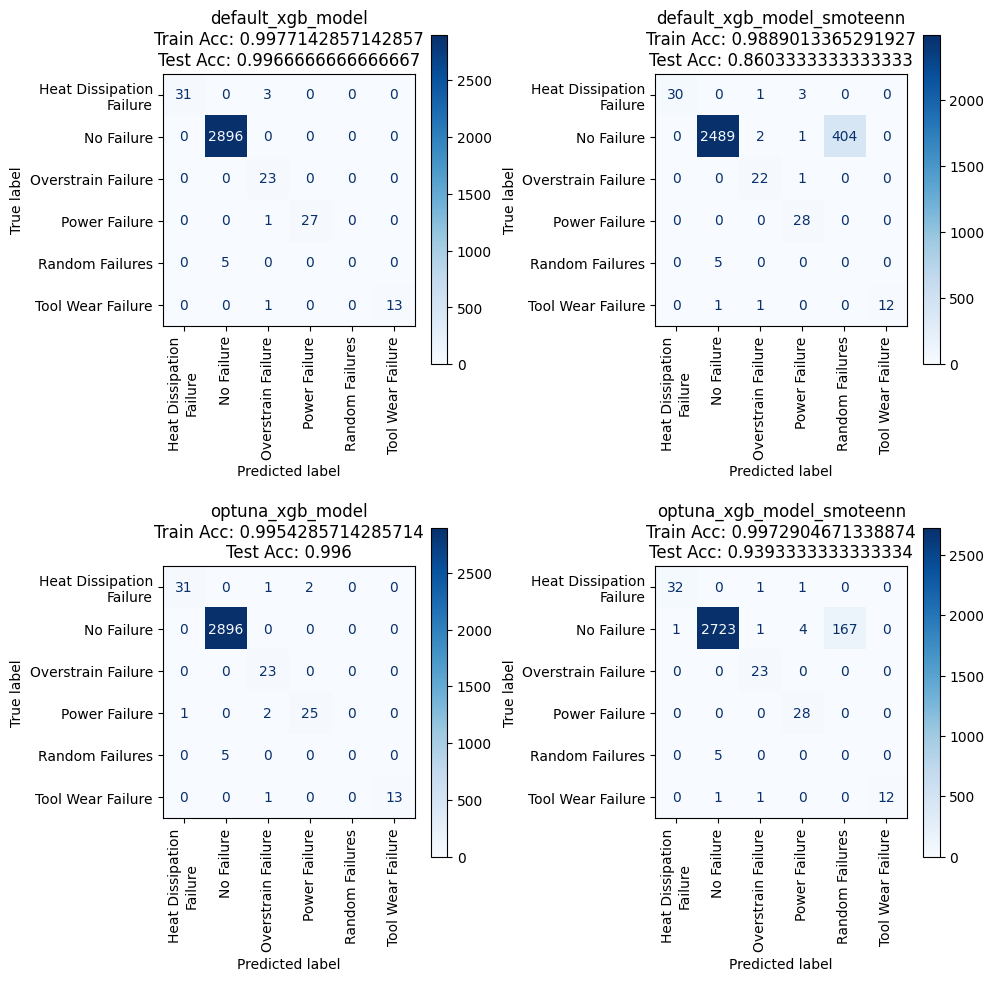

In [89]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
models = {
    "default_xgb_model": (default_xgb_model, X_train, X_test, y_train, y_test),
    "default_xgb_model_smoteenn": (default_xgb_model_smoteenn, X_train_smoteenn, X_test, y_train_smoteenn, y_test),
    "optuna_xgb_model": (optuna_xgb_model, X_train, X_test, y_train, y_test),
    "optuna_xgb_model_smoteenn": (optuna_xgb_model_smoteenn, X_train_smoteenn, X_test, y_train_smoteenn, y_test),
}

wrapper = textwrap.TextWrapper(width=18)

for ax, (model_name, (model, X_train_data, X_test_data, y_train_data, y_test_data)) in zip(axes.flatten(), models.items()):
    y_train_pred = model.predict(X_train_data)
    y_test_pred = model.predict(X_test_data)
    
    train_acc = accuracy_score(y_train_data, y_train_pred)
    test_acc = accuracy_score(y_test_data, y_test_pred)
    
    disp = ConfusionMatrixDisplay.from_predictions(y_test_data, y_test_pred, display_labels=label_encoder.classes_, cmap="Blues", ax=ax)
    # disp = ConfusionMatrixDisplay.from_predictions(y_test_data, y_test_pred, cmap="Blues", ax=ax)
    
    x_labels = ["\n".join(wrapper.wrap(label.get_text())) for label in ax.get_xticklabels()]
    ax.set_xticklabels(x_labels, rotation=90)
    # ax.set_xticklabels(x_labels)

    y_labels = ["\n".join(wrapper.wrap(label.get_text())) for label in ax.get_yticklabels()]
    ax.set_yticklabels(y_labels)
    
    ax.set_title(f"{model_name}\nTrain Acc: {train_acc}\nTest Acc: {test_acc}")

plt.tight_layout()
plt.show()

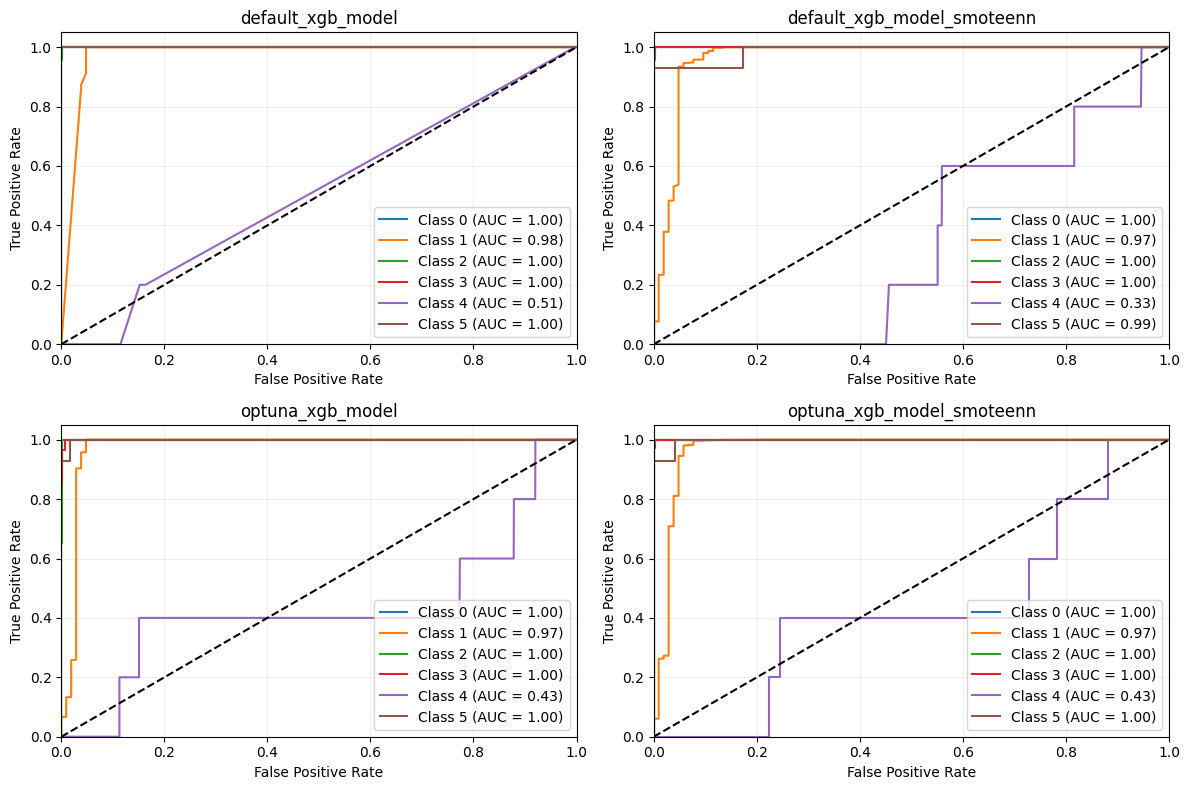

In [91]:
# Models and datasets mapping for multiclass classification
multiclass_models = {
    "default_xgb_model": (default_xgb_model, X_train, X_test, y_train, y_test),
    "default_xgb_model_smoteenn": (default_xgb_model_smoteenn, X_train_smoteenn, X_test, y_train_smoteenn, y_test),
    "optuna_xgb_model": (optuna_xgb_model, X_train, X_test, y_train, y_test),
    "optuna_xgb_model_smoteenn": (optuna_xgb_model_smoteenn, X_train_smoteenn, X_test, y_train_smoteenn, y_test),
}

# Get the number of models
num_models = len(multiclass_models)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# For each model, calculate the ROC curve and AUC for each class, then plot
for i, (model_name, (model, X_train_data, X_test_data, y_train_data, y_test_data)) in enumerate(multiclass_models.items()):
    # Get the number of classes
    num_classes = len(np.unique(y_train_data))

    # Initialize variables to store ROC curves and AUC values for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculate ROC curve and AUC for each class
    for class_label in range(num_classes):
        y_true_class = (y_test_data == class_label).astype(int)
        y_pred_prob_class = model.predict_proba(X_test_data)[:, class_label]
        fpr[class_label], tpr[class_label], _ = roc_curve(y_true_class, y_pred_prob_class)
        roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

    # Plot ROC curves for each class in the current subplot
    for class_label in range(num_classes):
        axes[i].plot(fpr[class_label], tpr[class_label], label=f"Class {class_label} (AUC = {roc_auc[class_label]:.2f})")
    axes[i].set_title(f'{model_name}')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].legend(loc="lower right")
    axes[i].plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
    axes[i].set_xlim([0, 1])
    axes[i].set_ylim([0, 1.05])
    axes[i].grid(alpha=0.2)

# Adjust the layout and display the subplots
plt.tight_layout()
plt.show()
